In [1]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt
import jenkspy

In [31]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['font.size'] = 12
plt.style.use('fivethirtyeight')

In [3]:
pd.set_option('display.max_columns', 50)
START_POI = 0
END_POI = 405
START_DATE = '2018-12-31'
TOTAL_DAYS = 400
TRAIN_RATIO = 0.7
VALID_RATIO = 0.2
TEST_RATIO = 1 - (TRAIN_RATIO + VALID_RATIO)
WINDOW_SIZE = 24
HORIZON = 6

pred_saved_path = f'/home/users/arash/NGA Project/POI/code/StemGNN/output/houston_data/train_{START_POI}_{END_POI}'


In [4]:
def masked_MAPE(v, v_, axis=None):
    '''
    Mean absolute percentage error.
    :param v: np.ndarray or int, ground truth.
    :param v_: np.ndarray or int, prediction.
    :param axis: axis to do calculation.
    :return: int, MAPE averages on all elements of input.
    '''
    # TODO: Remove this line
    v_ = np.where(v_<0, 0,v_)
    
    mask = (v < 1E-5)
    percentage = np.abs(v_ - v) / np.abs(v)
    percentage = np.where(percentage > 5, 5, percentage) # TODO remove this
    if np.any(mask):
        masked_array = np.ma.masked_array(percentage, mask=mask)  # mask the dividing-zero as invalid
        result = masked_array.mean(axis=axis)
        if isinstance(result, np.ma.MaskedArray):
            return result.filled(np.nan)
        else:
            return result
    return np.mean(percentage, axis).astype(np.float64)


def MAPE(v, v_, axis=None):
    '''
    Mean absolute percentage error.
    :param v: np.ndarray or int, ground truth.
    :param v_: np.ndarray or int, prediction.
    :param axis: axis to do calculation.
    :return: int, MAPE averages on all elements of input.
    '''
    # TODO: Remove this line
    v_ = np.where(v_<0, 0,v_)
    mape = (np.abs(v_ - v) / np.abs(v)+1e-5).astype(np.float64)
    mape = np.where(mape > 5, 5, mape)
    return np.mean(mape, axis)


def RMSE(v, v_, axis=None):
    '''
    Mean squared error.
    :param v: np.ndarray or int, ground truth.
    :param v_: np.ndarray or int, prediction.
    :param axis: axis to do calculation.
    :return: int, RMSE averages on all elements of input.
    '''
    return np.sqrt(np.mean((v_ - v) ** 2, axis)).astype(np.float64)




def MAE(v, v_, axis=None):
    '''
    Mean absolute error.
    :param v: np.ndarray or int, ground truth.
    :param v_: np.ndarray or int, prediction.
    :param axis: axis to do calculation.
    :return: int, MAE averages on all elements of input.
    '''

    return np.mean(np.abs(v_ - v), axis).astype(np.float64)


def evaluate(y, y_hat, by_step=False, by_node=False):
    '''
    :param y: array in shape of [count, time_step, node].
    :param y_hat: in same shape with y.
    :param by_step: evaluate by time_step dim.
    :param by_node: evaluate by node dim.
    :return: array of mape, mae and rmse.
    '''
    if not by_step and not by_node:
        return masked_MAPE(y, y_hat), MAE(y, y_hat), RMSE(y, y_hat)
    if by_step and by_node:
        return masked_MAPE(y, y_hat, axis=0), MAE(y, y_hat, axis=0), RMSE(y, y_hat, axis=0)
    if by_step:
        return masked_MAPE(y, y_hat, axis=(0, 2)), MAE(y, y_hat, axis=(0, 2)), RMSE(y, y_hat, axis=(0, 2))
    if by_node:
        return masked_MAPE(y, y_hat, axis=(0, 1)), MAE(y, y_hat, axis=(0, 1)), RMSE(y, y_hat, axis=(0, 1))

In [5]:
attention_scores = np.genfromtxt(f'{pred_saved_path}/attention_scores.csv', delimiter=',')

In [6]:
attention_scores.shape

(450, 450)

In [7]:
attention_scores.sum(axis=1)

array([ 0.80874743,  0.88642167,  1.24745803,  0.8170451 ,  1.14152148,
        0.91371184,  1.19969886,  0.99055837,  0.78542608,  0.94771802,
        0.85324885,  0.9050001 ,  1.05938426,  0.98169078,  0.76295124,
        1.2693679 ,  1.15728401,  1.06513175,  0.90729255,  1.30821939,
        0.93983318,  0.95212415,  0.93605215,  0.80661826,  1.08074541,
        1.63513862,  0.97908485,  0.82447107,  0.90167207,  0.80483193,
        1.00689431,  1.47454084,  0.9148531 ,  0.8005512 ,  0.99900508,
        0.96554897,  0.97209445,  0.7281688 ,  1.6850405 ,  1.2547318 ,
        1.06776245,  1.19838803,  1.58983362,  0.70330139,  0.79341718,
        0.81420775,  1.43212235,  1.1412736 ,  0.91837092,  1.01364368,
        1.28795379,  0.89940124,  0.85556301,  0.96209684,  1.12011167,
        0.86657882,  1.2057608 ,  0.89126401,  0.94670738,  0.90268053,
        1.39665147,  0.92579369,  0.92222214,  1.03510541,  1.30877307,
        0.90704279,  0.83576007,  0.84954825,  0.99762485,  0.74

In [8]:
# in-degrees
print('in-degrees for each node:', attention_scores.sum(axis=0))

# out-degrees
print('out-degrees for each node:', attention_scores.sum(axis=1))

in-degrees for each node: [ 0.80874743  0.88642167  1.24745803  0.8170451   1.14152148  0.91371184
  1.19969886  0.99055837  0.78542608  0.94771802  0.85324885  0.9050001
  1.05938426  0.98169078  0.76295124  1.2693679   1.15728401  1.06513175
  0.90729255  1.30821939  0.93983318  0.95212415  0.93605215  0.80661826
  1.08074541  1.63513862  0.97908485  0.82447107  0.90167207  0.80483193
  1.00689431  1.47454084  0.9148531   0.8005512   0.99900508  0.96554897
  0.97209445  0.7281688   1.6850405   1.2547318   1.06776245  1.19838803
  1.58983362  0.70330139  0.79341718  0.81420775  1.43212235  1.1412736
  0.91837092  1.01364368  1.28795379  0.89940124  0.85556301  0.96209684
  1.12011167  0.86657882  1.2057608   0.89126401  0.94670738  0.90268053
  1.39665147  0.92579369  0.92222214  1.03510541  1.30877307  0.90704279
  0.83576007  0.84954825  0.99762485  0.74482939  0.95722441  0.96662142
  0.9045884   0.74938328  0.75235494  1.48881046  0.78167813  0.79293601
  0.7357247   1.01202167  0

In [9]:
attention_scores.sum(axis=0)

array([ 0.80874743,  0.88642167,  1.24745803,  0.8170451 ,  1.14152148,
        0.91371184,  1.19969886,  0.99055837,  0.78542608,  0.94771802,
        0.85324885,  0.9050001 ,  1.05938426,  0.98169078,  0.76295124,
        1.2693679 ,  1.15728401,  1.06513175,  0.90729255,  1.30821939,
        0.93983318,  0.95212415,  0.93605215,  0.80661826,  1.08074541,
        1.63513862,  0.97908485,  0.82447107,  0.90167207,  0.80483193,
        1.00689431,  1.47454084,  0.9148531 ,  0.8005512 ,  0.99900508,
        0.96554897,  0.97209445,  0.7281688 ,  1.6850405 ,  1.2547318 ,
        1.06776245,  1.19838803,  1.58983362,  0.70330139,  0.79341718,
        0.81420775,  1.43212235,  1.1412736 ,  0.91837092,  1.01364368,
        1.28795379,  0.89940124,  0.85556301,  0.96209684,  1.12011167,
        0.86657882,  1.2057608 ,  0.89126401,  0.94670738,  0.90268053,
        1.39665147,  0.92579369,  0.92222214,  1.03510541,  1.30877307,
        0.90704279,  0.83576007,  0.84954825,  0.99762485,  0.74

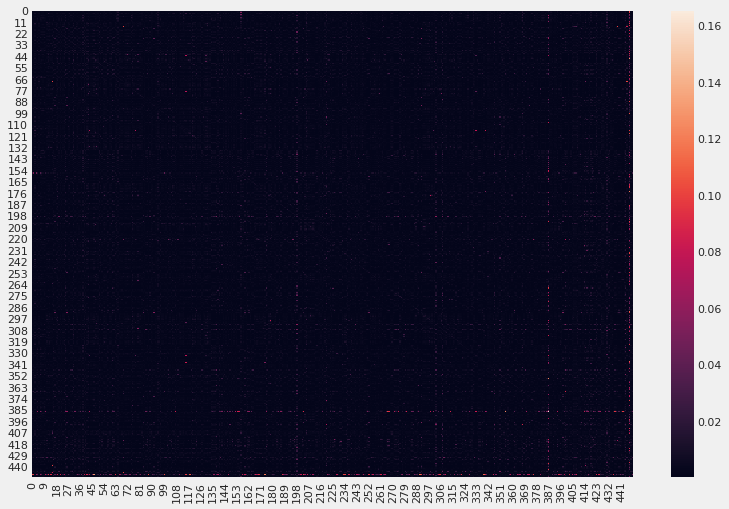

In [39]:
sns.heatmap(attention_scores)
plt.savefig(f"img/Aug 25/attention_matrix.png", bbox_inches = 'tight')

In [40]:
preds_data = np.genfromtxt(f'{pred_saved_path}/predict.csv', delimiter=',')
target_data = np.genfromtxt(f'{pred_saved_path}/target.csv', delimiter=',')

In [41]:
df = pd.DataFrame(columns=['mape'])
df

,mape


In [42]:
nodes_mape_series = pd.Series(masked_MAPE(target_data, preds_data, axis=0))
nodes_mape_series

0      0.303587
1      0.415092
2      0.493680
3      0.442568
4      0.382563
         ...   
400    0.522484
401    0.548598
402    0.525438
403    0.429755
404    0.506616
Length: 405, dtype: float64

In [43]:
df['mape'] = nodes_mape_series
df

,mape
0,0.303587
1,0.415092
2,0.493680
3,0.442568
4,0.382563
...,...
400,0.522484
401,0.548598
402,0.525438
403,0.429755


In [44]:
in_degrees_series = pd.Series(np.median(attention_scores, axis=0))
df['in_degrees'] = in_degrees_series
df

,mape,in_degrees
0,0.303587,0.001333
1,0.415092,0.001183
2,0.493680,0.001725
3,0.442568,0.001182
4,0.382563,0.001431
...,...,...
400,0.522484,0.000918
401,0.548598,0.001583
402,0.525438,0.000837
403,0.429755,0.000775


In [45]:
jnb = jenkspy.JenksNaturalBreaks(4)
jnb.fit(in_degrees_series)
jnb.breaks_

[0.0005396049236878753,
 0.001132241275627166,
 0.0015907601919025183,
 0.002866785740479827,
 0.007735428865998983]

In [46]:
jnb.breaks_[:3] + [jnb.breaks_[4]]

[0.0005396049236878753,
 0.001132241275627166,
 0.0015907601919025183,
 0.007735428865998983]

In [47]:
# df['degrees_cut'] = pd.qcut(in_degrees_series, q=3)
df['degrees_cut'] = pd.cut(in_degrees_series, bins=jnb.breaks_[:3] + [jnb.breaks_[4]], include_lowest=True)
df

,mape,in_degrees,degrees_cut
0,0.303587,0.001333,"(0.00113, 0.00159]"
1,0.415092,0.001183,"(0.00113, 0.00159]"
2,0.493680,0.001725,"(0.00159, 0.00774]"
3,0.442568,0.001182,"(0.00113, 0.00159]"
4,0.382563,0.001431,"(0.00113, 0.00159]"
...,...,...,...
400,0.522484,0.000918,"(-0.00046, 0.00113]"
401,0.548598,0.001583,"(0.00113, 0.00159]"
402,0.525438,0.000837,"(-0.00046, 0.00113]"
403,0.429755,0.000775,"(-0.00046, 0.00113]"


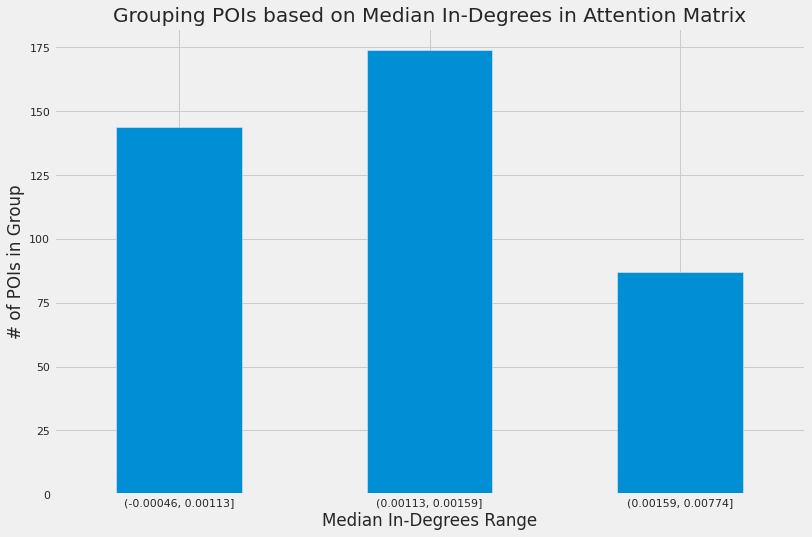

In [76]:
ax = df.groupby('degrees_cut')['degrees_cut'].count().plot(kind='bar', rot=0)
ax.set_ylabel('# of POIs in Group')
ax.set_xlabel('Median In-Degrees Range')
ax.set_title('Grouping POIs based on Median In-Degrees in Attention Matrix')
plt.savefig(f"img/Aug 25/group_counts_in_degrees_attention_matrix.png", bbox_inches = 'tight')

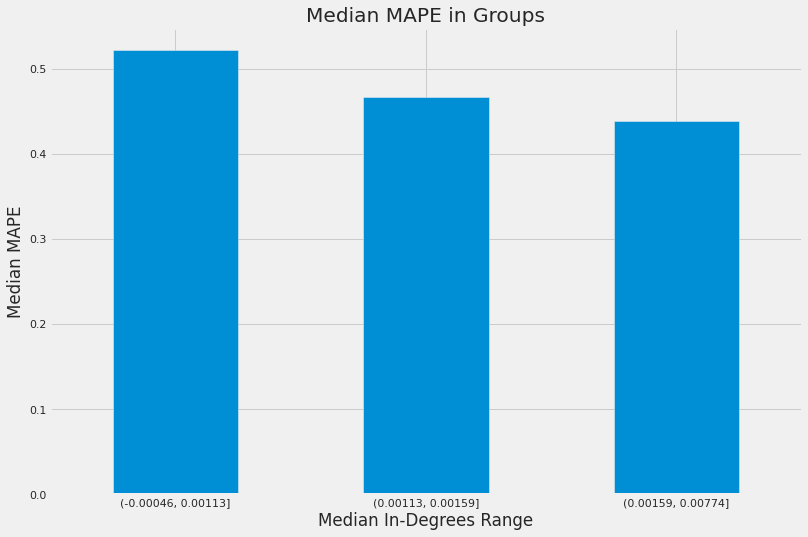

In [77]:
ax = df.groupby('degrees_cut')['mape'].median().plot(kind='bar', rot=0)
ax.set_ylabel('Median MAPE')
ax.set_xlabel('Median In-Degrees Range')
ax.set_title('Median MAPE in Groups')
plt.savefig(f"img/Aug 25/group_mape_in_degrees_attention_matrix.png", bbox_inches = 'tight')

/home/users/arash/anaconda3/envs/torch_env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


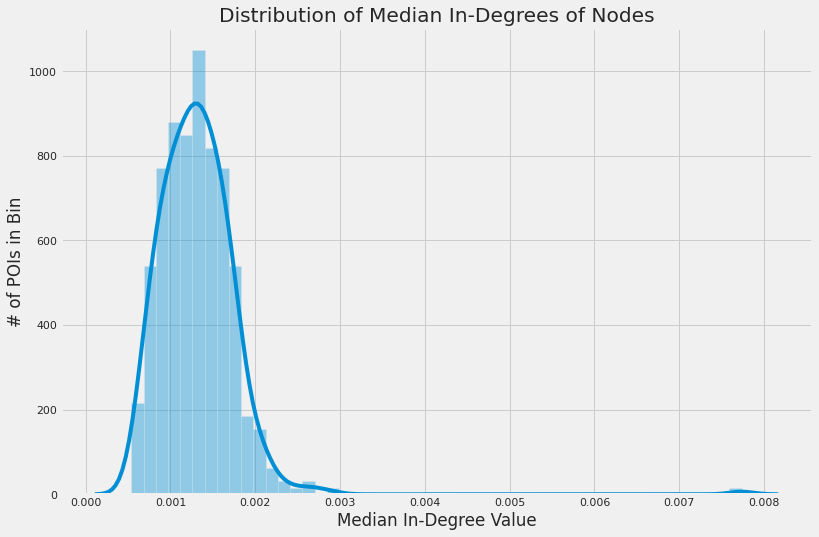

In [80]:
ax = sns.distplot(in_degrees_series)
ax.set_ylabel('# of POIs in Bin')
ax.set_xlabel('Median In-Degree Value')
ax.set_title('Distribution of Median In-Degrees of Nodes')
plt.savefig(f"img/Aug 25/median_in_degrees_dist_attention_matrix.png", bbox_inches = 'tight')